In [ ]:
# Import all necessary libraries for the workflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# --- Google Colab Integration ---
# Mount Google Drive to save and access files
from google.colab import drive
drive.mount('/content/drive')

# --- Settings ---
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Setup complete. Google Drive is mounted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete. Google Drive is mounted.


In [ ]:
# --- IMPORTANT: UPDATE THIS PATH ---
# Set the path to your dataset in Google Drive
file_path = '/content/drive/MyDrive/Combined_Coastal_Biomass_Dataset.csv'
# ------------------------------------

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please check the name and path.")

# --- Data Cleaning ---
# Drop columns that are not useful for modeling
if '.geo' in df.columns and 'system:index' in df.columns:
    df_cleaned = df.drop(columns=['.geo', 'system:index'])
else:
    df_cleaned = df.copy()


# IMPORTANT: Drop rows where the target variables are missing
initial_rows = len(df_cleaned)
df_cleaned.dropna(subset=['Biomass_AGB', '3_ocd'], inplace=True)
final_rows = len(df_cleaned)
print(f"Dropped {initial_rows - final_rows} rows with missing target values.")

# Rename 'ocd' to '3_ocd' for clarity and consistency
if 'ocd' in df_cleaned.columns:
    df_cleaned.rename(columns={'ocd': '3_ocd'}, inplace=True)

df_cleaned.head()

Dataset loaded successfully.
Shape of the dataset: (33459, 25)
Dropped 0 rows with missing target values.


,0_sand,1_silt,2_clay,3_ocd,4_cec,5_nitrogen,6_bdod,7_cfvo,8_phh2o,Biomass_AGB,...,Precipitation,SAR_VH,SAR_VV,SAVI,Slope,Temperature,State,Blue_Carbon_Density,longitude,latitude
0,452.00000,243.33333,305.16666,159.50000,238.16667,947.5000,145.00000,196.833330,69.833336,0.980,...,33.083333,-17.264852,-10.068697,0.215009,1.210323,348.083333,Andhra Pradesh,159.96060,77.543846,14.352904
1,253.83333,363.66666,383.33334,169.33333,278.00000,1193.1666,155.50000,141.333330,71.666664,0.800,...,105.250000,-15.857327,-6.268812,0.217338,0.474143,334.750000,Andhra Pradesh,169.70933,78.652622,19.039967
2,408.16666,287.00000,306.00000,227.83333,257.16666,1307.3334,133.33333,105.000000,63.000000,3.119,...,98.833333,-14.576346,-8.480621,0.583907,1.720288,316.583333,Andhra Pradesh,229.29926,82.182849,17.592073
3,254.33333,368.33334,377.66666,163.83333,272.66666,962.3333,148.16667,181.666670,70.833336,2.870,...,96.250000,-15.875746,-9.064580,0.622986,1.186647,337.000000,Andhra Pradesh,165.18223,79.067817,18.870599
4,304.83334,398.50000,297.33334,252.83333,204.16667,1854.1666,133.83333,52.666668,66.166664,8.914,...,74.750000,-18.599726,-9.696587,0.559607,0.083665,332.750000,Andhra Pradesh,257.02291,80.689567,16.082891


In [ ]:
# --- Calculate Carbon Credits ---

# Define the conversion factors
BIOMASS_TO_CARBON_FACTOR = 0.47  # Assumes biomass is 47% carbon
CARBON_TO_CO2E_FACTOR = 3.67     # Molecular weight ratio of CO2 to C (44.01 / 12.01)

# Make a copy to add the new column
df_with_credits = df_cleaned.copy()

# Use the original, untransformed biomass and soil carbon values
original_biomass = df_with_credits['Biomass_AGB']
soil_organic_carbon = df_with_credits['3_ocd']

# Apply the formula to calculate carbon credits (in tons of CO2 equivalent per hectare)
df_with_credits['Carbon_Credits'] = ((original_biomass * BIOMASS_TO_CARBON_FACTOR) + soil_organic_carbon) * CARBON_TO_CO2E_FACTOR

print("'Carbon_Credits' column added successfully.")
# Display the first few rows with the new column
df_with_credits[['Biomass_AGB', '3_ocd', 'Carbon_Credits']].head()

'Carbon_Credits' column added successfully.


,Biomass_AGB,3_ocd,Carbon_Credits
0,0.980,159.50000,587.055402
1,0.800,169.33333,622.833241
2,3.119,227.83333,841.528285
3,2.870,163.83333,606.218784
4,8.914,252.83333,943.274080


In [ ]:
if df is not None:
    # 1. Define targets and all columns to exclude from features
    targets = ['3_ocd', 'Biomass_AGB']

    # --- CRITICAL FIX HERE ---
    # Create a list of all columns to exclude from our input features.
    # This prevents data leakage and errors from non-numeric columns.
    cols_to_exclude = ['3_ocd', 'Biomass_AGB', 'Blue_Carbon_Density', 'State', 'Carbon_Credits','longitude','latitude']

    # Define features as all columns EXCEPT the ones in our exclude list
    features = [col for col in df_cleaned.columns if col not in cols_to_exclude]
    print("--- Features being used for the model ---")
    print(features)
    # --- END OF FIX ---

    X = df_cleaned[features]
    y = df_cleaned[targets]

    # 2. Log-transform the 'Biomass_AGB' target variable
    y['Biomass_AGB'] = np.log1p(y['Biomass_AGB'])

    # 3. Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"\nData split into training and testing sets:")
    print(f"X_train shape: {X_train.shape}")

--- Features being used for the model ---
['0_sand', '1_silt', '2_clay', '4_cec', '5_nitrogen', '6_bdod', '7_cfvo', '8_phh2o', 'EVI', 'Elevation', 'MSAVI', 'NDVI', 'NDWI', 'Precipitation', 'SAR_VH', 'SAR_VV', 'SAVI', 'Slope', 'Temperature']

Data split into training and testing sets:
X_train shape: (26767, 19)


/tmp/ipython-input-3129231895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Biomass_AGB'] = np.log1p(y['Biomass_AGB'])


In [ ]:
# Identify column groups for different processing steps
# Adjust these lists if your final dataset has different column names
veg_features = [col for col in ['NDVI', 'NDWI', 'EVI', 'SAVI'] if col in X_train.columns]
sar_features = [col for col in ['SAR_VV', 'SAR_VH'] if col in X_train.columns]
numeric_features = [col for col in X_train.columns if col not in veg_features + sar_features]

# Create a pipeline for standard numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a pipeline for vegetation features (includes PCA)
veg_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=42)) # Combine veg indices into 1 component
])

# Create a pipeline for SAR features (includes PCA)
sar_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=42)) # Combine SAR bands into 1 component
])

# Use ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('veg', veg_transformer, veg_features),
        ('sar', sar_transformer, sar_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


In [ ]:
# Define the model
hgb_regressor = HistGradientBoostingRegressor(random_state=42)
multi_output_model = MultiOutputRegressor(hgb_regressor)

# Create the full pipeline by chaining the preprocessor and the model
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', multi_output_model)
])

# Define the hyperparameter grid to search
# Note the syntax: 'step_name__estimator__parameter_name'
param_grid = {
    'regressor__estimator__max_iter': [200, 300],
    'regressor__estimator__max_leaf_nodes': [31, 41],
    'regressor__estimator__learning_rate': [0.05, 0.1]
}

# Set up GridSearchCV to find the best parameters for the entire pipeline
grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("--- Starting Hyperparameter Tuning ---")
# Fit the grid search on the training data. This will train the entire pipeline.
grid_search.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R² score on cross-validation: {grid_search.best_score_:.4f}")

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Hyperparameter Tuning Complete ---
Best parameters found: {'regressor__estimator__learning_rate': 0.05, 'regressor__estimator__max_iter': 300, 'regressor__estimator__max_leaf_nodes': 41}
Best R² score on cross-validation: 0.9069


In [ ]:
# The best model is already trained on the full training data, so we can use it directly
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics for each target variable
r2_soc = r2_score(y_test['3_ocd'], y_pred[:, 0])
rmse_soc = np.sqrt(mean_squared_error(y_test['3_ocd'], y_pred[:, 0]))

r2_biomass = r2_score(y_test['Biomass_AGB'], y_pred[:, 1])
rmse_biomass = np.sqrt(mean_squared_error(y_test['Biomass_AGB'], y_pred[:, 1]))

# Display the final results
print("\n" + "="*30)
print("   FINAL MODEL TEST RESULTS")
print("="*30)
print(f"Target 1: Soil Organic Carbon (3_ocd)")
print(f"  R-squared (R²): {r2_soc:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_soc:.4f}")
print("-" * 25)
print(f"Target 2: Biomass_AGB (log-transformed)")
print(f"  R-squared (R²): {r2_biomass:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_biomass:.4f}")
print("="*30)


   FINAL MODEL TEST RESULTS
Target 1: Soil Organic Carbon (3_ocd)
  R-squared (R²): 0.9617
  Root Mean Squared Error (RMSE): 10.6642
-------------------------
Target 2: Biomass_AGB (log-transformed)
  R-squared (R²): 0.8657
  Root Mean Squared Error (RMSE): 0.4064


--- Visualizing Feature Importance using Permutation Importance ---


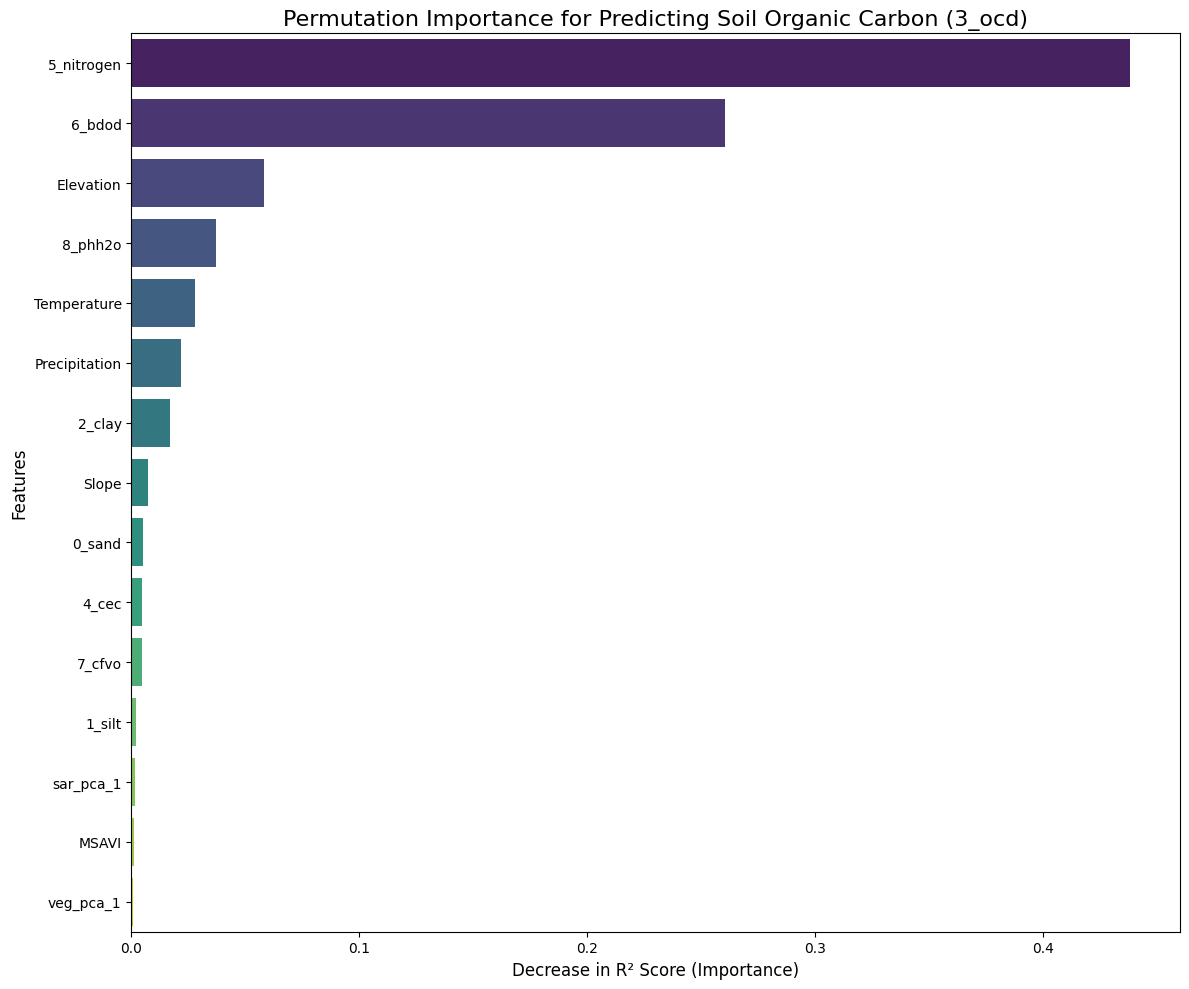

In [ ]:
if df is not None:
    print("--- Visualizing Feature Importance using Permutation Importance ---")
    try:
        preprocessor_fitted = best_model.named_steps['preprocessor']
        X_test_transformed = preprocessor_fitted.transform(X_test)
        soc_model = best_model.named_steps['regressor'].estimators_[0]

        result = permutation_importance(
            soc_model, X_test_transformed, y_test['3_ocd'],
            n_repeats=10, random_state=42, n_jobs=-1, scoring='r2'
        )

        numeric_cols = preprocessor_fitted.named_transformers_['num'].get_feature_names_out(numeric_features)
        final_feature_names = list(numeric_cols)
        if veg_features: final_feature_names.append('veg_pca_1')
        if sar_features: final_feature_names.append('sar_pca_1')

        importances_df = pd.Series(result.importances_mean, index=final_feature_names).sort_values(ascending=False)

        plt.figure(figsize=(12, 10))
        sns.barplot(x=importances_df.values, y=importances_df.index, palette='viridis')
        plt.title('Permutation Importance for Predicting Soil Organic Carbon (3_ocd)', fontsize=16)
        plt.xlabel('Decrease in R² Score (Importance)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate feature importance plot. Error: {e}")

--- Visualizing Feature Importance for Biomass_AGB ---


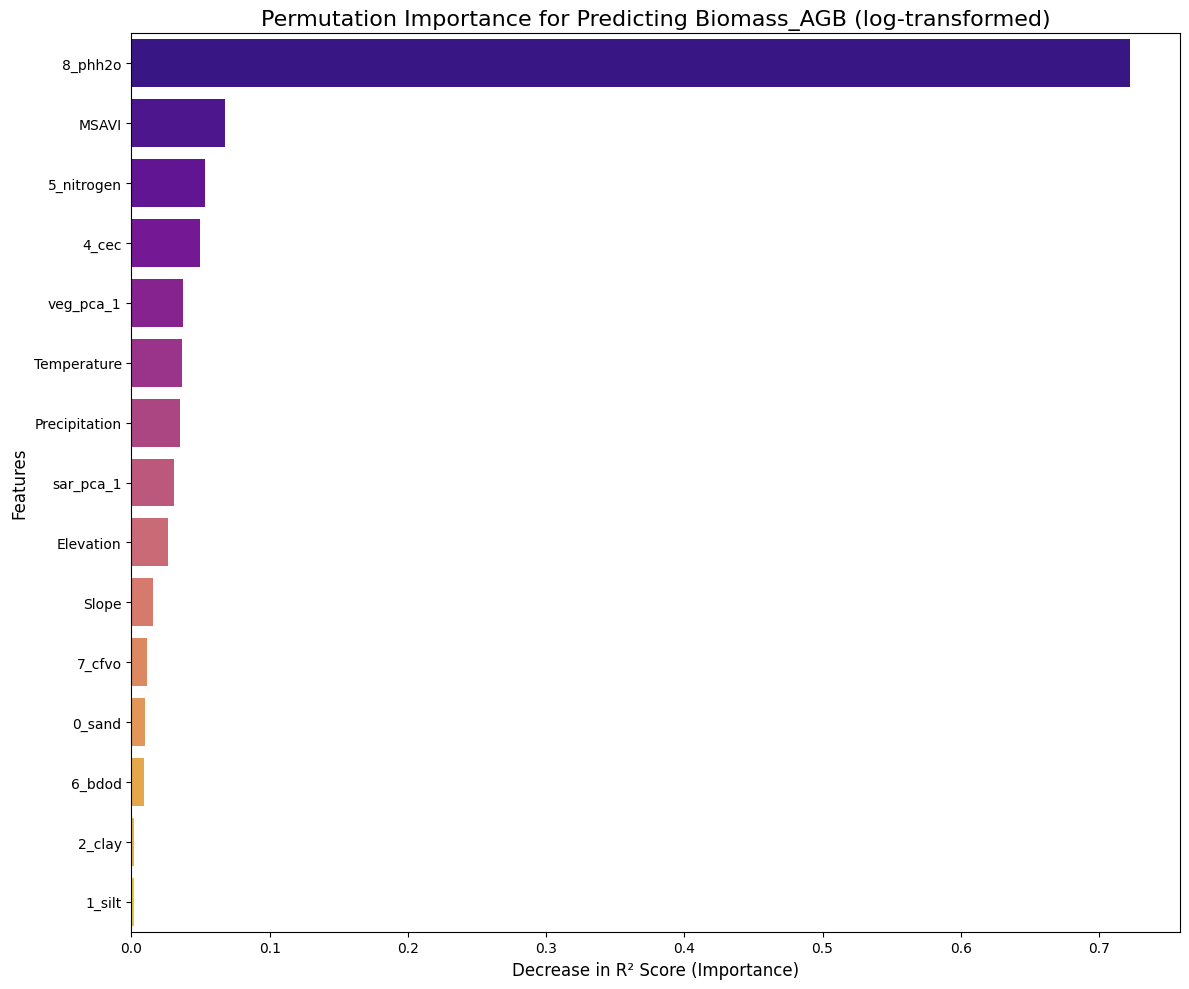

In [ ]:
# ==============================================================================
# CELL: VISUALIZE FEATURE IMPORTANCE FOR BIOMASS
# ==============================================================================
if df is not None:
    print("--- Visualizing Feature Importance for Biomass_AGB ---")
    try:
        # --- Step 1: We use the same preprocessed test data as before ---
        # preprocessor_fitted and X_test_transformed are already available from the previous cell

        # --- Step 2: Isolate the already-trained model for Biomass ---
        # The model for Biomass_AGB is the SECOND estimator (index 1)
        biomass_model = best_model.named_steps['regressor'].estimators_[1]

        # --- Step 3: Calculate permutation importance for Biomass ---
        # We now compare the shuffled predictions against the 'Biomass_AGB' column
        result_biomass = permutation_importance(
            biomass_model,
            X_test_transformed,
            y_test['Biomass_AGB'], # Target is now Biomass
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring='r2'
        )

        # --- Step 4: Get feature names and plot the results ---
        # The feature names are the same as before
        numeric_cols = preprocessor_fitted.named_transformers_['num'].get_feature_names_out(numeric_features)
        final_feature_names = list(numeric_cols)
        if veg_features: final_feature_names.append('veg_pca_1')
        if sar_features: final_feature_names.append('sar_pca_1')

        # Create a pandas Series for easy plotting
        importances_df_biomass = pd.Series(result_biomass.importances_mean, index=final_feature_names).sort_values(ascending=False)

        # Plot the feature importances
        plt.figure(figsize=(12, 10))
        sns.barplot(x=importances_df_biomass.values, y=importances_df_biomass.index, palette='plasma')
        plt.title('Permutation Importance for Predicting Biomass_AGB (log-transformed)', fontsize=16)
        plt.xlabel('Decrease in R² Score (Importance)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not generate feature importance plot for Biomass. Error: {e}")

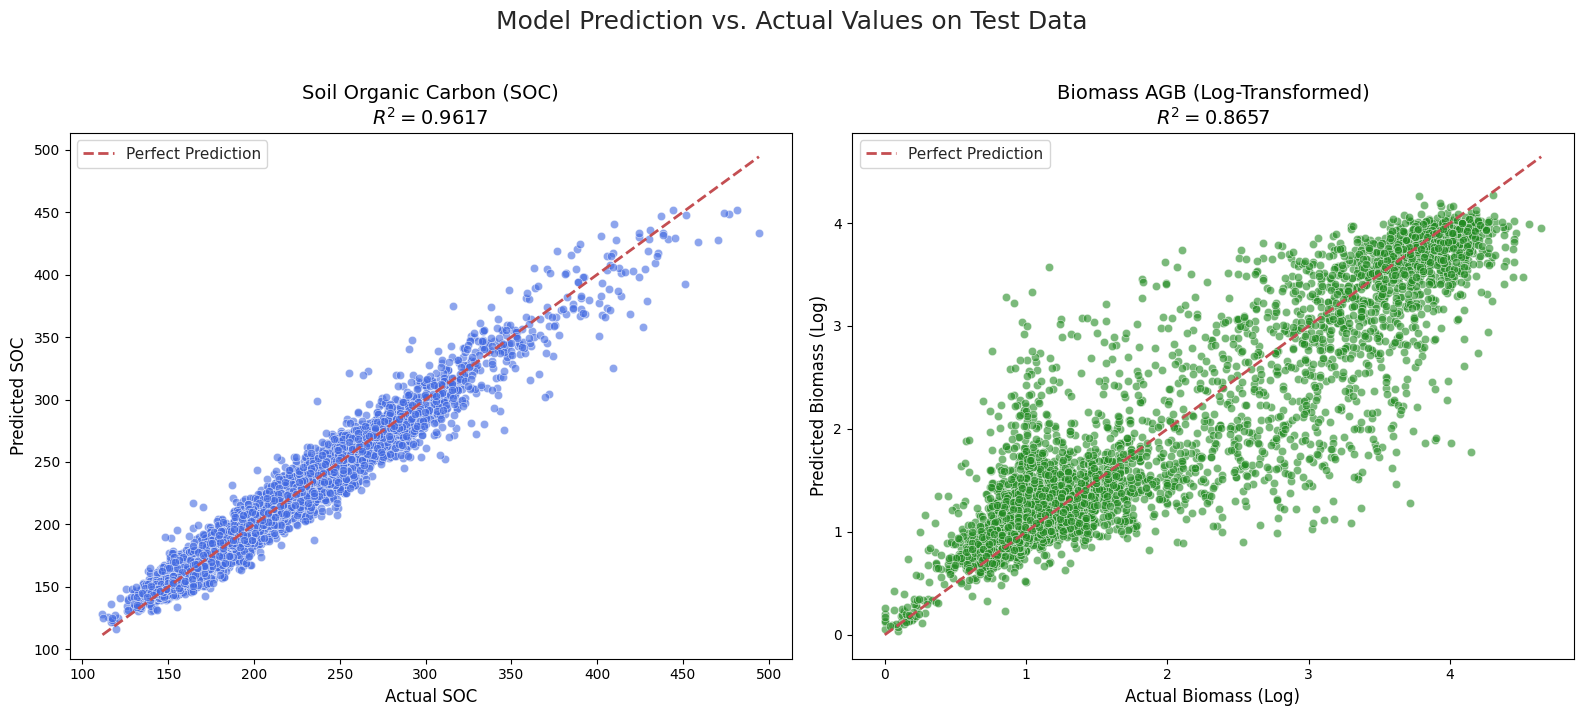

In [ ]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Actual_SOC': y_test['3_ocd'],
    'Predicted_SOC': y_pred[:, 0],
    'Actual_Biomass_AGB': y_test['Biomass_AGB'],
    'Predicted_Biomass_AGB': y_pred[:, 1]
})

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_theme(style="whitegrid")

# Plot for Soil Organic Carbon
axes[0].set_title(f'Soil Organic Carbon (SOC)\n$R^2 = {r2_soc:.4f}$', fontsize=14)
sns.scatterplot(data=results_df, x='Actual_SOC', y='Predicted_SOC', ax=axes[0], alpha=0.6, color='royalblue')
axes[0].plot([y_test['3_ocd'].min(), y_test['3_ocd'].max()], [y_test['3_ocd'].min(), y_test['3_ocd'].max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual SOC", fontsize=12)
axes[0].set_ylabel("Predicted SOC", fontsize=12)
axes[0].legend()

# Plot for Biomass AGB
axes[1].set_title(f'Biomass AGB (Log-Transformed)\n$R^2 = {r2_biomass:.4f}$', fontsize=14)
sns.scatterplot(data=results_df, x='Actual_Biomass_AGB', y='Predicted_Biomass_AGB', ax=axes[1], alpha=0.6, color='forestgreen')
axes[1].plot([y_test['Biomass_AGB'].min(), y_test['Biomass_AGB'].max()], [y_test['Biomass_AGB'].min(), y_test['Biomass_AGB'].max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel("Actual Biomass (Log)", fontsize=12)
axes[1].set_ylabel("Predicted Biomass (Log)", fontsize=12)
axes[1].legend()

plt.suptitle('Model Prediction vs. Actual Values on Test Data', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# --- Data Preparation (Assuming X and y were prepared as in the training code) ---
df = pd.read_csv('Goa_Biomass_Dataset_2023.csv')
targets = ['3_ocd', 'Biomass_AGB']
cols_to_exclude = targets + ['Carbon_Credits', '.geo', 'system:index']
df_cleaned = df.drop(columns=[col for col in ['.geo', 'system:index'] if col in df.columns], errors='ignore')
df_cleaned['Carbon_Credits'] = 0 # Placeholder for Carbon_Credits as it was created in the training step
features = [col for col in df_cleaned.columns if col not in cols_to_exclude and col not in targets]

X = df_cleaned[features]
y = df_cleaned[targets].copy()
y['Biomass_AGB'] = np.log1p(y['Biomass_AGB'])
# --- Feature Groups for Preprocessing (Must match training structure) ---
veg_features = [col for col in ['NDVI', 'NDWI', 'EVI', 'SAVI'] if col in X_train.columns]
sar_features = [col for col in ['SAR_VV', 'SAR_VH'] if col in X_train.columns]
numeric_features = [col for col in X_train.columns if col not in veg_features + sar_features]

# --- Define Preprocessor ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
veg_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=42))
])
sar_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=1, random_state=42))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('veg', veg_transformer, veg_features),
        ('sar', sar_transformer, sar_features)
    ],
    remainder='passthrough'
)

# --- Define Final Optimized Model (Using Best Parameters) ---
best_hgb_regressor = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=300,
    max_leaf_nodes=41,
    random_state=42
)
multi_output_model = MultiOutputRegressor(best_hgb_regressor)

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', multi_output_model)
])

# Re-train the final model on the training data (essential step if not loaded)
final_pipeline.fit(X, y)

# --- TESTING: Make predictions on the test set ---
y_pred = final_pipeline.predict(X)

# --- Evaluation ---
r2_soc = r2_score(y['3_ocd'], y_pred[:, 0])
rmse_soc = np.sqrt(mean_squared_error(y['3_ocd'], y_pred[:, 0]))

r2_biomass = r2_score(y['Biomass_AGB'], y_pred[:, 1])
rmse_biomass = np.sqrt(mean_squared_error(y['Biomass_AGB'], y_pred[:, 1]))

print("\n--- FINAL MODEL TEST RESULTS (Optimized Pipeline) ---")
print(f"Soil Organic Carbon (3_ocd) R²: {r2_soc:.4f}")
print(f"Biomass_AGB (log) R²: {r2_biomass:.4f}")



--- FINAL MODEL TEST RESULTS (Optimized Pipeline) ---
Soil Organic Carbon (3_ocd) R²: 0.9833
Biomass_AGB (log) R²: 0.9614


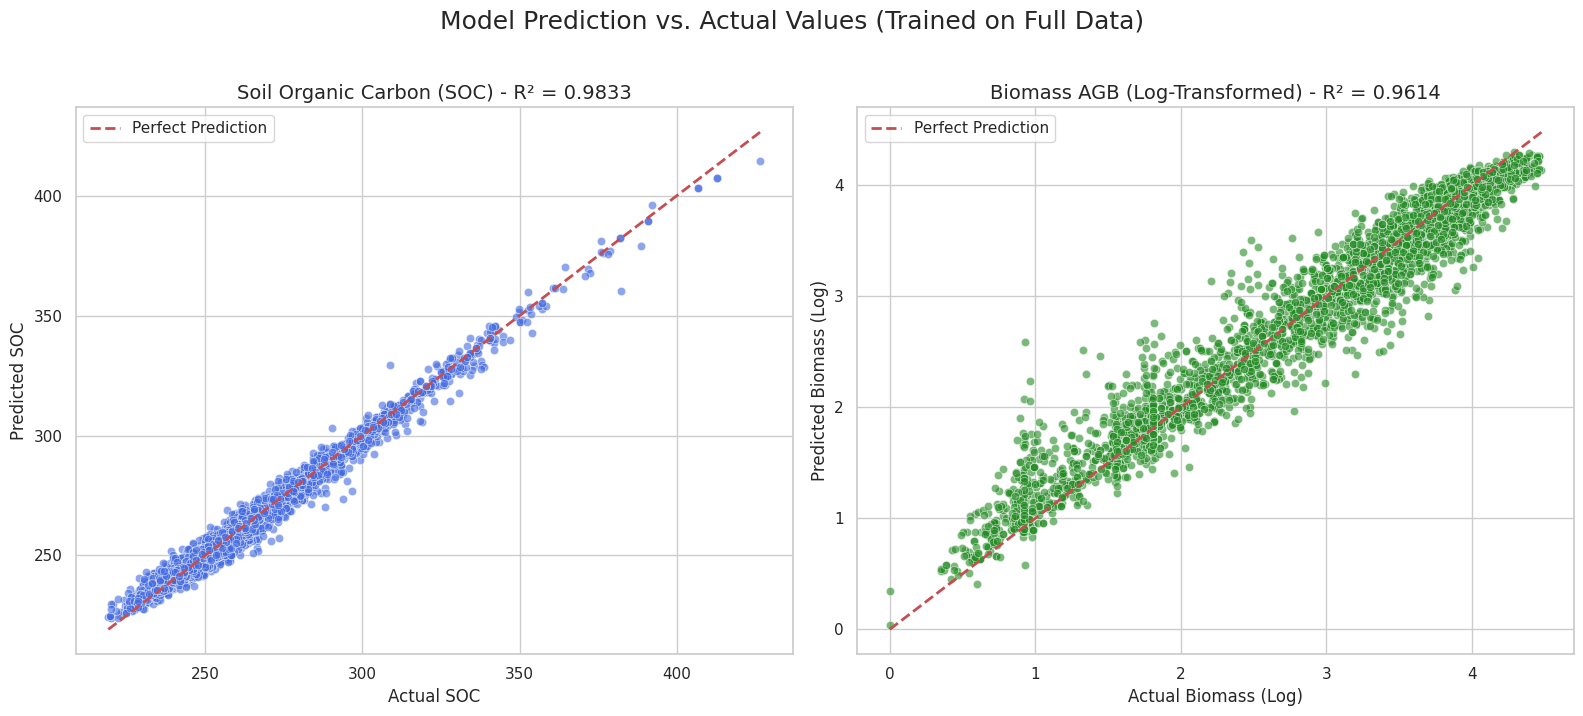

In [ ]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Actual_SOC': y['3_ocd'],
    'Predicted_SOC': y_pred[:, 0],
    'Actual_Biomass_AGB': y['Biomass_AGB'],
    'Predicted_Biomass_AGB': y_pred[:, 1]
})

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_theme(style="whitegrid")

# Plot for Soil Organic Carbon
axes[0].set_title(f'Soil Organic Carbon (SOC) - R² = {r2_soc:.4f}', fontsize=14)
sns.scatterplot(data=results_df, x='Actual_SOC', y='Predicted_SOC', ax=axes[0], alpha=0.6, color='royalblue')
soc_min, soc_max = y['3_ocd'].min(), y['3_ocd'].max()
axes[0].plot([soc_min, soc_max], [soc_min, soc_max], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel("Actual SOC", fontsize=12)
axes[0].set_ylabel("Predicted SOC", fontsize=12)
axes[0].legend()

# Plot for Biomass AGB
axes[1].set_title(f'Biomass AGB (Log-Transformed) - R² = {r2_biomass:.4f}', fontsize=14)
sns.scatterplot(data=results_df, x='Actual_Biomass_AGB', y='Predicted_Biomass_AGB', ax=axes[1], alpha=0.6, color='forestgreen')
biomass_min, biomass_max = y['Biomass_AGB'].min(), y['Biomass_AGB'].max()
axes[1].plot([biomass_min, biomass_max], [biomass_min, biomass_max], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel("Actual Biomass (Log)", fontsize=12)
axes[1].set_ylabel("Predicted Biomass (Log)", fontsize=12)
axes[1].legend()

plt.suptitle('Model Prediction vs. Actual Values (Trained on Full Data)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
